In [1]:
import sys
sys.path.insert(1, '../model')
import model
import linear_model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.ticker import ScalarFormatter
import optuna
optuna.logging.disable_default_handler()
import pandas as pd
pd.plotting.register_matplotlib_converters()
import seaborn as sns
from scipy.integrate import solve_ivp

In [3]:
raw = pd.read_csv("../data/covid_19_data.csv")

In [4]:
#load population dict
population_df = pd.read_csv("../data/locations_population.csv")
population_country = population_df[population_df['Country.Region'] == "Czechia"].iloc[0]['Population']
population_country = int(population_country)
print(population_country) 

10650000


In [5]:
raw

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
42987,42988,06/15/2020,Zacatecas,Mexico,2020-06-16 04:33:09,550.0,58.0,324.0
42988,42989,06/15/2020,Zakarpattia Oblast,Ukraine,2020-06-16 04:33:09,1680.0,42.0,686.0
42989,42990,06/15/2020,Zaporizhia Oblast,Ukraine,2020-06-16 04:33:09,529.0,16.0,335.0
42990,42991,06/15/2020,Zhejiang,Mainland China,2020-06-16 04:33:09,1268.0,1.0,1267.0


In [6]:
data_cols = ["Infected", "Deaths", "Recovered"]
data_cols_all = ["Confirmed", "Infected", "Deaths", "Recovered"]
df = raw.rename({"ObservationDate": "Date", "Province/State": "Province"}, axis=1)
df["Date"] = pd.to_datetime(df["Date"])
df["Country"] = df["Country/Region"]
df.loc[df["Country"] == "Diamond Princess", ["Country", "Province"]] = ["Others", "Diamond Princess"]
df["Infected"] = df["Confirmed"] - df["Deaths"] - df["Recovered"]
df[data_cols_all] = df[data_cols_all].astype(np.int64)
ncov_df_ungrouped = df.loc[:, ["Date", "Country", "Province", *data_cols_all]]
ncov_df_ungrouped.tail()

,Date,Country,Province,Confirmed,Infected,Deaths,Recovered
42987,2020-06-15,Mexico,Zacatecas,550,168,58,324
42988,2020-06-15,Ukraine,Zakarpattia Oblast,1680,952,42,686
42989,2020-06-15,Ukraine,Zaporizhia Oblast,529,178,16,335
42990,2020-06-15,Mainland China,Zhejiang,1268,0,1,1267
42991,2020-06-15,Ukraine,Zhytomyr Oblast,1087,521,19,547


In [7]:
df_germany = ncov_df_ungrouped.loc[ncov_df_ungrouped["Country"] == "Czech Republic", :].groupby("Date").sum()
df_germany['Country'] = 'Czech Republic'
df_germany['Province'] = None
df_germany.tail()

,Confirmed,Infected,Deaths,Recovered,Country,Province
Date,,,,,,
2020-06-11,9855,2361,328,7166,Czech Republic,None
2020-06-12,9938,2394,329,7215,Czech Republic,None
2020-06-13,9991,2444,328,7219,Czech Republic,None
2020-06-14,10024,2469,329,7226,Czech Republic,None
2020-06-15,10064,2438,330,7296,Czech Republic,None


In [8]:
df_test = pd.read_csv("../data/full-list-total-tests-for-covid-19.csv")
df_test.rename({"Cumulative total tests": "TotalTests"}, axis=1,inplace=True)
df_test["Date"] = pd.to_datetime(df_test["Date"])
df_test_germany = df_test[df_test['Entity'] == 'Czech Republic']
df_test_germany.tail()

,Entity,Code,Date,TotalTests
281,Czech Republic,CZE,2020-04-09,114854
282,Czech Republic,CZE,2020-04-10,120285
283,Czech Republic,CZE,2020-04-11,125126
284,Czech Republic,CZE,2020-04-12,128359
285,Czech Republic,CZE,2020-04-13,131542


In [9]:
result = pd.merge(df_germany,
                 df_test_germany[['Date','TotalTests']],
                 on='Date',
                 how = 'left')
from numpy import isnan
result.loc[0, ('TotalTests')] = 0 if isnan(result['TotalTests'][0]) else result['TotalTests'][0]
result['TotalTests'].interpolate(method='linear',inplace=True,limit_direction='both')
result['TotalTests'] = result['TotalTests'].astype(int)
border_date = '2020-06-10'
training = result[(result['Date'] > '2020-01-01') & (result['Date'] < border_date)]
test = result[result['Date'] >= border_date]
result.tail()


,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
102,2020-06-11,9855,2361,328,7166,Czech Republic,None,131542
103,2020-06-12,9938,2394,329,7215,Czech Republic,None,131542
104,2020-06-13,9991,2444,328,7219,Czech Republic,None,131542
105,2020-06-14,10024,2469,329,7226,Czech Republic,None,131542
106,2020-06-15,10064,2438,330,7296,Czech Republic,None,131542


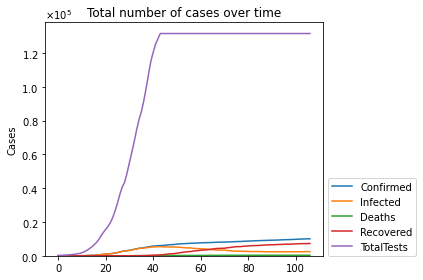

In [10]:
data_cols_all += ['TotalTests']
model.line_plot(result[data_cols_all], "Total number of cases over time")

In [11]:
ger_scenario = model.Scenario(training, name="Czech Republic", places=[("Czech Republic", None)])

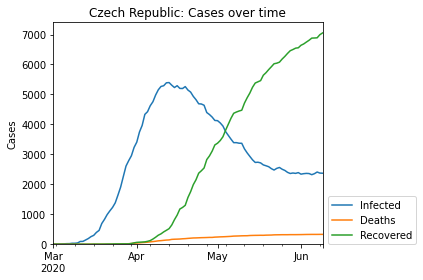

,Date,Confirmed,Infected,Deaths,Recovered
96,2020-06-05,9529,2321,327,6881
97,2020-06-06,9567,2355,327,6885
98,2020-06-07,9628,2410,327,6891
99,2020-06-08,9697,2375,328,6994
100,2020-06-09,9751,2370,328,7053


In [12]:
ger_scenario.show_record().tail()

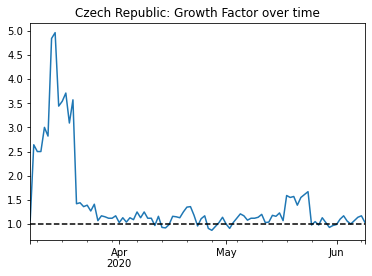

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Czech Republic,2020-06-09,Crossroad,4,0


In [13]:
ger_scenario.growth_factor()

In [14]:
result.loc[result['Date'] == '2020-04-13']

,Date,Confirmed,Infected,Deaths,Recovered,Country,Province,TotalTests
43,2020-04-13,6059,5397,143,519,Czech Republic,None,131542


In [15]:
ger_scenario.set_phase(
    start_dates=["25Mar2020","07Apr2020","22Apr2020"],
    population=population_country
)

,start_date,end_date,population
1st,25Mar2020,06Apr2020,10650000
2nd,07Apr2020,21Apr2020,10650000
3rd,22Apr2020,-,10650000


In [16]:
ger_scenario.estimate(model.SIR)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 7 sec.
	Successfully estimated.
Total: 0 min 23 sec.


In [17]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,rho,sigma,Rt,score,1/beta [day],1/gamma [day]
1st,25Mar2020,06Apr2020,10650000,1229,0.090363,0.004171,21.67,0.176633,9,204
2nd,07Apr2020,21Apr2020,10650000,1229,0.024973,0.018253,1.37,0.079987,34,46
3rd,22Apr2020,-,10650000,1229,0.013619,0.030599,0.45,0.055271,62,27


../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


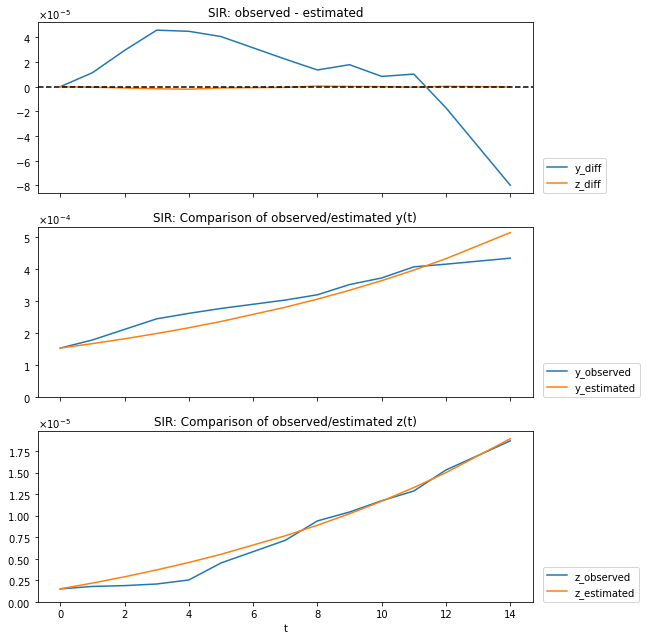

In [18]:
ger_scenario.accuracy_graph(phase_n=1)

../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


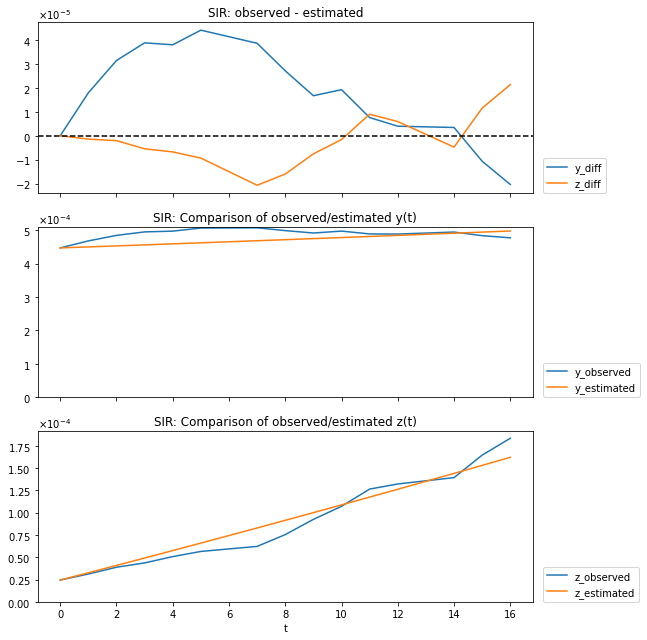

In [19]:
ger_scenario.accuracy_graph(phase_n=2)

../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


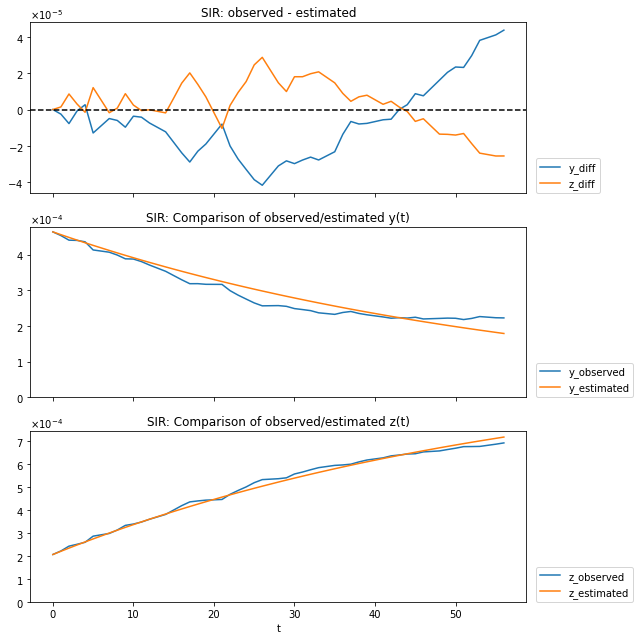

In [20]:
ger_scenario.accuracy_graph(phase_n=3)

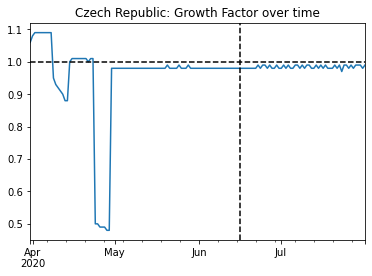

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Czech Republic,2020-07-31 20:59:00,Stopping,0,117


In [21]:
ger_scenario.growth_factor(days_to_predict=100)

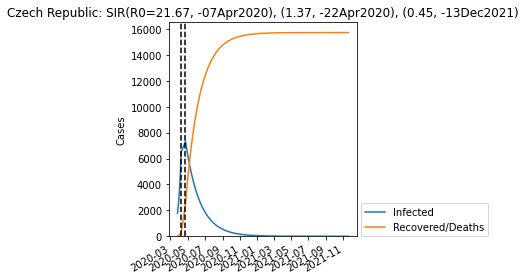

In [22]:
df_sir = ger_scenario.predict(days=600)

In [23]:
df_sir.loc['2020-05-02':'2020-05-08']

,Susceptible,Infected,Recovered/Deaths
Time,,,
2020-05-02 09:45:00,10639141,6084,4773
2020-05-03 06:14:00,10639059,5982,4958
2020-05-04 02:43:00,10638978,5881,5139
2020-05-04 23:12:00,10638899,5782,5318
2020-05-05 19:41:00,10638821,5684,5493
2020-05-06 16:10:00,10638744,5588,5666
2020-05-07 12:39:00,10638669,5494,5835
2020-05-08 09:08:00,10638595,5402,6002


SEIR MODEL

In [24]:
ger_scenario.set_phase(
    start_dates=["25Mar2020","07Apr2020","22Apr2020"],
    population=population_country
)

,start_date,end_date,population
1st,25Mar2020,06Apr2020,10650000
2nd,07Apr2020,21Apr2020,10650000
3rd,22Apr2020,-,10650000


In [25]:
ger_scenario.estimate(model.SIRD)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 9 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
	Successfully estimated.
Total: 0 min 26 sec.


In [26]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,kappa,rho,sigma,Rt,score,1/alpha2 [day],1/beta [day],1/gamma [day]
1st,25Mar2020,06Apr2020,10650000,1255,0.001821,0.093403,0.002255,22.92,0.249485,478,9,386
2nd,07Apr2020,21Apr2020,10650000,1255,0.001510,0.025853,0.017471,1.36,0.109512,577,33,49
3rd,22Apr2020,-,10650000,1255,0.000730,0.014027,0.030441,0.45,0.056589,1193,62,28


../model/model.py:762: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


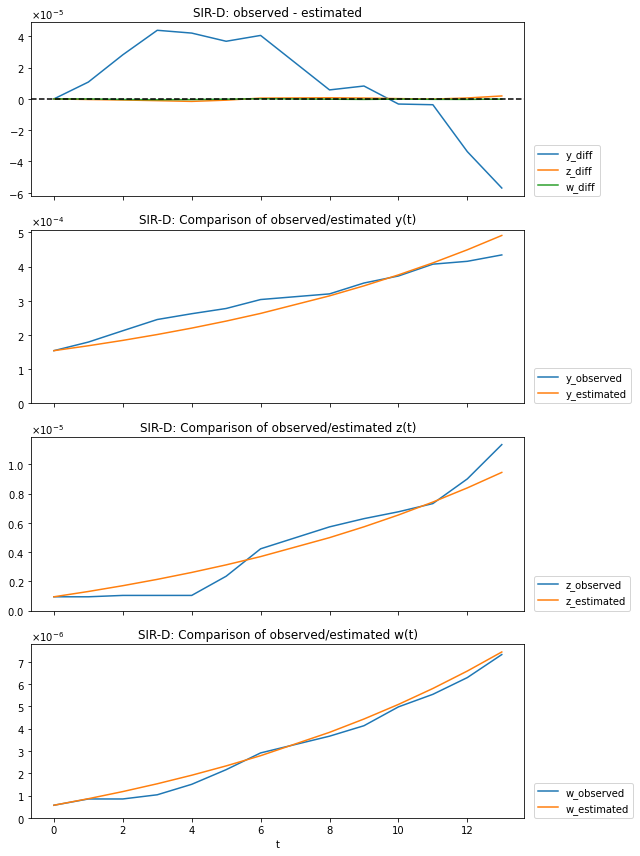

In [27]:
ger_scenario.accuracy_graph(phase_n=1)

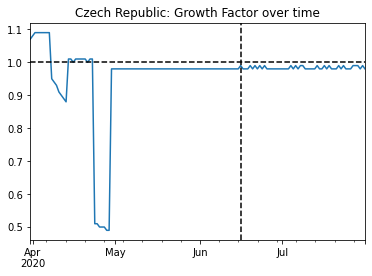

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Czech Republic,2020-07-31 02:45:00,Stopping,0,114


In [28]:
ger_scenario.growth_factor(days_to_predict=100)

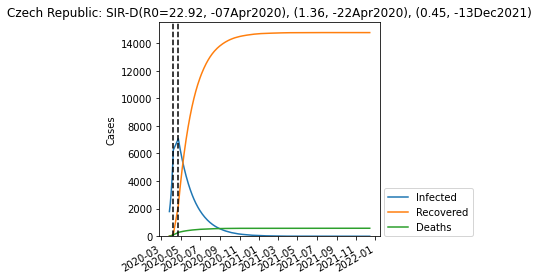

In [29]:
df_seir = ger_scenario.predict(days=600)

In [30]:
df_seir.loc['2020-05-02':'2020-05-08']

,Susceptible,Infected,Recovered,Deaths
Time,,,,
2020-05-02 08:20:00,10639433,5856,4377,332
2020-05-03 05:15:00,10639351,5756,4554,336
2020-05-04 02:10:00,10639271,5658,4728,341
2020-05-04 23:05:00,10639193,5562,4898,345
2020-05-05 20:00:00,10639116,5467,5066,349
2020-05-06 16:55:00,10639040,5374,5231,353
2020-05-07 13:50:00,10638965,5283,5394,357
2020-05-08 10:45:00,10638891,5193,5553,360


SEIRD MODEL

In [31]:
ger_scenario.estimate(model.SIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 13 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 16 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 11 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 8 sec.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 10 sec.
	Successfully estimated.
Total: 2 min 47 sec.


In [32]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,theta,kappa,rho,sigma,Rt,score,alpha1 [-],1/alpha2 [day],1/beta [day],1/gamma [day]
1st,25Mar2020,06Apr2020,10650000,942,0.003153,0.000956,0.060562,0.001800,21.90,0.278560,0.003,684,10,363
2nd,07Apr2020,21Apr2020,10650000,942,0.063168,0.000298,0.014030,0.012409,1.03,0.118070,0.063,2195,46,52
3rd,22Apr2020,-,10650000,942,0.064017,0.000046,0.009701,0.022049,0.41,0.063991,0.064,14265,67,29


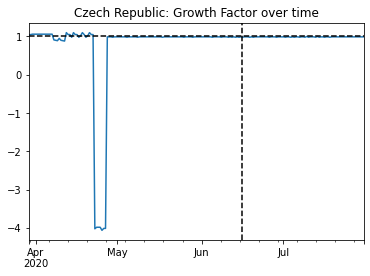

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Czech Republic,2020-07-30 13:30:00,Stopping,0,26


In [33]:
ger_scenario.growth_factor(days_to_predict=100)

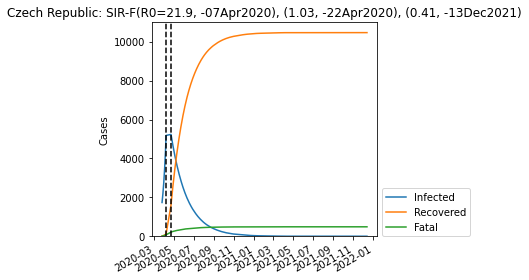

In [34]:
df_seird = ger_scenario.predict(days=600)

In [35]:
df_seird.loc['2020-05-02':'2020-05-08']

,Susceptible,Infected,Recovered,Fatal,Confirmed
Time,,,,,
2020-05-02 14:18:00,10642206,4250,3274,268,7792
2020-05-03 06:00:00,10642165,4195,3367,271,7833
2020-05-03 21:42:00,10642125,4140,3459,274,7873
2020-05-04 13:24:00,10642085,4087,3550,277,7914
2020-05-05 05:06:00,10642045,4034,3639,279,7952
2020-05-05 20:48:00,10642006,3982,3728,282,7992
2020-05-06 12:30:00,10641968,3930,3815,285,8030
2020-05-07 04:12:00,10641930,3879,3901,287,8067
2020-05-07 19:54:00,10641893,3829,3986,290,8105


SEWIRF

In [36]:
ger_scenario.estimate(model.SEWIRF)

Hyperparameter estimation of 1st phase.
	Estimator was created.
		100 trials finished in 0 min 9 sec.
		100 trials finished in 0 min 11 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 17 sec.
		100 trials finished in 0 min 18 sec.
		100 trials finished in 0 min 19 sec.
		100 trials finished in 0 min 20 sec.
		100 trials finished in 0 min 22 sec.
		100 trials finished in 0 min 26 sec.
	Successfully estimated.
Hyperparameter estimation of 2nd phase.
	Estimator was created.
		100 trials finished in 0 min 11 sec.
	Successfully estimated.
Hyperparameter estimation of 3rd phase.
	Estimator was created.
		100 trials finished in 0 min 11 sec.
	Estimator will be replaced because estimated z is non-monotonic.
	Estimator was created.
		100 trials finished in 0 min 10 sec.
		100 trials finished in 0 min 12 sec.
		100 trials finished in 0 min 14 sec.
		100 trials finished in 0 min 15 sec.
		100 trials finished in 0 min 16 sec.
		100 

In [37]:
ger_scenario.show_parameters()

,start_date,end_date,population,tau,theta,kappa,rho1,rho2,rho3,sigma,Rt,score,alpha1 [-],1/alpha2 [day],1/beta1 [day],1/beta2 [day],1/beta3 [day],1/gamma [day]
1st,25Mar2020,06Apr2020,10650000,1267,0.016160,0.000206,0.247346,0.186651,0.509369,0.002840,79.91,0.342065,0.016,4276,3,4,1,309
2nd,07Apr2020,21Apr2020,10650000,1267,0.283624,0.001456,0.008038,0.829815,0.088576,0.022025,0.25,0.223758,0.284,604,109,1,9,39
3rd,22Apr2020,-,10650000,1267,0.038427,0.000491,0.015734,0.142989,0.156488,0.030507,0.49,0.062583,0.038,1793,55,6,5,28


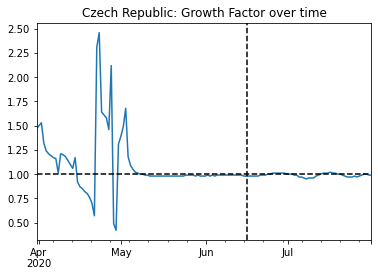

,Date,Group,GF > 1 [straight days],GF < 1 [straight days]
Czech Republic,2020-07-31 11:02:00,Crossroad,0,2


In [38]:
ger_scenario.growth_factor(days_to_predict=100)

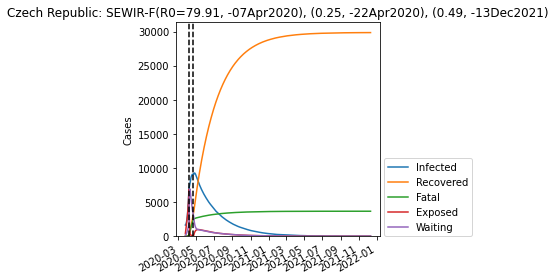

In [39]:
df_sewirf = ger_scenario.predict(days=600)

In [40]:
df_sewirf.loc['2020-05-02':'2020-05-08']

,Susceptible,Infected,Recovered,Fatal,Exposed,Waiting,Confirmed
Time,,,,,,,
2020-05-02 17:08:00,10630010,8690,6568,2697,938,1095,17955
2020-05-03 14:15:00,10629857,8586,6831,2708,955,1060,18125
2020-05-04 11:22:00,10629707,8480,7091,2718,968,1033,18289
2020-05-05 08:29:00,10629558,8373,7348,2729,977,1012,18450
2020-05-06 05:36:00,10629412,8266,7602,2739,983,995,18607
2020-05-07 02:43:00,10629268,8159,7853,2749,987,983,18761
2020-05-07 23:50:00,10629125,8053,8100,2758,988,973,18911
2020-05-08 20:57:00,10628984,7950,8344,2768,987,963,19062


# comparison 

In [43]:
def getValuesVector(df, label):
    d = ''
    arr = []
    for index, row in df.loc['2020-06-10':'2020-06-15'].iterrows():
        ind = str(index).split(" ")[0]
        if (d == ind):
            arr[-1] = round((arr[-1] + row[label]) / 2, 0)
        else:
            arr.append(row[label])
        d = ind
    return arr

def getComparison(df_sewirf, df_seird, df_sird, df_sir, label):
    fit = linear_model.fitFuntion(training, label)
    x, y = linear_model.getDataSet(result, label)
    func = fit['function']
    popt = fit['popt']
     
    df = pd.DataFrame()
    df["sewirf_" + label] = getValuesVector(df_sewirf.loc['2020-06-10':'2020-06-15'], label)
    df["sirf_" + label] = getValuesVector(df_seird.loc[['2020-06-10':'2020-06-15'], label)
    df["sird_" + label] = getValuesVector(df_sird.loc[['2020-06-10':'2020-06-15'], label)
    df["sir_" + label] = getValuesVector(df_sir.loc[['2020-06-10':'2020-06-15'], label)
    df["function_fit_" + label] = func(x, *popt)[-7:-1]
    df[label] = list(test[label])
    
    squareError = pd.DataFrame()
    squareError["sewirf_" + label] = np.square(list(df["sewirf_" + label] - df[label]))
    squareError["sirf_" + label] = np.square(list(df["sirf_" + label] - df[label]))
    squareError["sird_" + label] = np.square(list(df["sird_" + label] - df[label]))
    squareError["sir_" + label] = np.square(list(df["sir_" + label] - df[label]))
    squareError["function_fit_" + label] = np.square(list(df["function_fit_" + label] - df[label]))

    return (df, squareError)

SyntaxError: invalid syntax (<ipython-input-43-449e5eb9804a>, line 21)

In [44]:
comp, squareError = getComparison(df_sewirf, df_seird, df_seir, df_sir, "Infected")

ValueError: Length of values does not match length of index

In [ ]:
comp

In [ ]:
squareError

In [ ]:
1/7 * squareError.sum()

PREDICTING IN PHASES

TRYING TO INCLUDE TESTS